In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [44]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [45]:
A,D = 1.0,1.0
delta_t=1
M=1000 # number of data sets
N=50000 # length of data set
print(np.exp(-delta_t*D/A))

0.36787944117144233


In [46]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUanalytic(data)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

In [47]:
print('A mean, A std: ',result_Bayes_array.T[0].mean(),result_Bayes_array.T[1].mean())
print('B mean, B std: ',result_Bayes_array.T[2].mean(),result_Bayes_array.T[3].mean())
print('B min, B max: ',result_Bayes_array.T[2].min(),result_Bayes_array.T[2].max())

A mean, A std:  0.9998685221391844 0.007246937436565234
B mean, B std:  0.3679695524342603 0.004158336458884751
B min, B max:  0.35609393519623966 0.38046701347327805


(array([ 13.,  38.,  92., 157., 217., 223., 156.,  74.,  22.,   8.]),
 array([0.35609394, 0.35853124, 0.36096855, 0.36340586, 0.36584317,
        0.36828047, 0.37071778, 0.37315509, 0.3755924 , 0.37802971,
        0.38046701]),
 <a list of 10 Patch objects>)

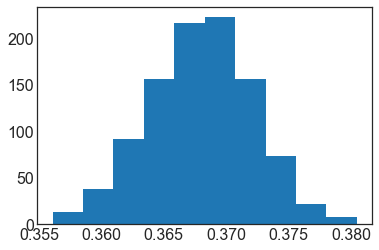

In [48]:
plt.hist(result_Bayes_array.T[2])